In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.data.download_data import download_from_google_drive
from src.definitions import ROOT_DIR, KEYS_TO_ORDINAL, KEYS_TO_LITHOLOGY
from src.definitions import ORDINAL_TO_KEYS, ORDINAL_TO_LITHOLOGY, LITHOLOGY_TO_ORDINAL
from src.model.train_model import score

In [2]:
%load_ext autoreload
%autoreload 2

In [78]:
plt.style.use('seaborn-poster')

# Import data

The model fitting was done in colab using notebook 9.0. Unfortunatelly, the model saving methods `.save()` class method, and pickle, didn't produce the same predicted probabilities using the loaded models as compared to the ones predictied using the in-memory models. The loaded models predicted probabilities had were all the same value.

As a result, I decided to do the fit and predict in colab, and then save the predictions. In this notebook, we load these predictions.

## y_pred

In [4]:
models_proba_path = ROOT_DIR / 'data/raw/models_proba_grouped/00_hidden'

In [5]:
file_ids = {
    'models_proba_grouped_baat_gp.csv': '1-3Snqoml-FstqX8Ln2phxm9_7ZoKynqm',
    'models_proba_grouped_cromer_knoll_gp.csv': '1-6WwNZp6Rs5uwX2imOcONeGC73O_MDdy',
    'models_proba_grouped_dunlin_gp.csv': '1-AgduLYBJ5VsMRBoe5Wmbq5lxVZ_m5e7',
    'models_proba_grouped_hegre_gp.csv': '1-CU0KI0pb9scPPS1zl5rFX_icnK4ojoq',
    'models_proba_grouped_hordaland_gp.csv': '1-GcLRZ8lJZY0e0SFtZViZCUUcMc0DkZg',
    'models_proba_grouped_nordland_gp.csv': '1-Gll6Siro1ecdMRL89TBgZ-MPoDU8bVr',
    'models_proba_grouped_permian_gp.csv': '1-H__qwVBQ4m60skb-FRd2TaSMhUKFIY-',
    'models_proba_grouped_rogaland_gp.csv': '1-HvguPVorvo1WOWTePM1Glu6tArJ2lDW',
    'models_proba_grouped_shetland_gp.csv': '1-MXeMmyL5y9XOCnHJqcty0yEQoJ3e9YH',
    'models_proba_grouped_vestland_gp.csv': '1-Nov8-9oX4zgqCK2eM5cI_XTZTeq8our',
    'models_proba_grouped_vtb_gp.csv': '1-Q7f-bB8wB0zcmEVt8VI5oco0ca8ky2P'
}

In [7]:
download_from_google_drive(file_ids, output_root=models_proba_path)

Downloading...
From: https://drive.google.com/uc?id=1-3Snqoml-FstqX8Ln2phxm9_7ZoKynqm
To: /media/hdd/projects/springboard/force_2020_lith/data/raw/models_proba_grouped/00_hidden/models_proba_grouped_baat_gp.csv
100%|██████████| 1.45M/1.45M [00:00<00:00, 4.36MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6WwNZp6Rs5uwX2imOcONeGC73O_MDdy
To: /media/hdd/projects/springboard/force_2020_lith/data/raw/models_proba_grouped/00_hidden/models_proba_grouped_cromer_knoll_gp.csv
4.34MB [00:00, 26.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-AgduLYBJ5VsMRBoe5Wmbq5lxVZ_m5e7
To: /media/hdd/projects/springboard/force_2020_lith/data/raw/models_proba_grouped/00_hidden/models_proba_grouped_dunlin_gp.csv
3.40MB [00:00, 22.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-CU0KI0pb9scPPS1zl5rFX_icnK4ojoq
To: /media/hdd/projects/springboard/force_2020_lith/data/raw/models_proba_grouped/00_hidden/models_proba_grouped_hegre_gp.csv
100%|██████████| 476k/476k [00:00<00:00, 1

In [8]:
models_probas = []
for file in models_proba_path.glob('*.csv'):
    model_proba = pd.read_csv(file)
    
    # Get GROUPED name from filename
    group = file.stem
    group = group.split('_', maxsplit=3)[3]
    
    # Assign group to keep track of data origin
    model_proba['GROUPED'] = group
    
    models_probas.append(model_proba)
    
models_probas = pd.concat(models_probas, ignore_index=True)

In [9]:
models_probas.columns

Index(['Sandstone', 'Sandstone/Shale', 'Shale', 'Marl', 'Dolomite',
       'Limestone', 'Chalk', 'Coal', 'MODEL', 'index', 'WELL', 'DEPTH_MD',
       'GROUPED', 'Anhydrite', 'Halite', 'Basement', 'Tuff'],
      dtype='object')

In [10]:
cols_ordered = ['Sandstone', 'Sandstone/Shale', 'Shale', 'Marl', 'Dolomite',
                'Limestone', 'Chalk', 'Coal', 'Anhydrite', 'Halite', 'Basement', 'Tuff',
                'GROUPED', 'MODEL', 'index', 'WELL', 'DEPTH_MD'
               ]

In [11]:
models_probas = models_probas.loc[:, cols_ordered]

In [12]:
models_probas.fillna(0.0, inplace=True)

In [13]:
models_probas.sample(10)

,Sandstone,Sandstone/Shale,Shale,Marl,Dolomite,Limestone,Chalk,Coal,Anhydrite,Halite,Basement,Tuff,GROUPED,MODEL,index,WELL,DEPTH_MD
570353,0.036506,0.023781,0.924740,0.003755,0.002963,0.004332,0.000000,0.000000,0.000000,0.0,0.0,0.003921,hordaland_gp,3,63074,31/2-10,767.368000
374960,0.031020,0.151550,0.778627,0.012886,0.005406,0.016241,0.004270,0.000000,0.000000,0.0,0.0,0.000000,shetland_gp,1,84594,34/3-2 S,3465.702800
186835,0.211836,0.513979,0.197418,0.000000,0.022989,0.027191,0.000000,0.026587,0.000000,0.0,0.0,0.000000,vestland_gp,4,11033,15/9-23,3208.216000
393934,0.025412,0.016612,0.487172,0.219327,0.010227,0.211972,0.029279,0.000000,0.000000,0.0,0.0,0.000000,shetland_gp,2,58821,25/10-9,2637.552800
586545,0.002182,0.010329,0.984230,0.000572,0.000704,0.001289,0.000000,0.000000,0.000000,0.0,0.0,0.000695,hordaland_gp,4,14883,16/2-7,1284.756002
478219,0.011574,0.023547,0.947312,0.002506,0.004682,0.007279,0.000000,0.000000,0.000000,0.0,0.0,0.003099,hordaland_gp,0,25101,16/7-6,1468.894400
241141,0.039386,0.034920,0.896352,0.006271,0.003544,0.013372,0.000000,0.000000,0.000000,0.0,0.0,0.006155,rogaland_gp,3,113830,35/9-7,1671.874800
113049,0.019101,0.097042,0.866863,0.004427,0.002401,0.005348,0.000000,0.002474,0.002345,0.0,0.0,0.000000,vtb_gp,4,73563,31/2-21 S,2532.384400
114651,0.086061,0.245227,0.612148,0.016392,0.007681,0.017073,0.000000,0.007916,0.007502,0.0,0.0,0.000000,vtb_gp,4,75165,31/2-21 S,2775.888400
341850,0.043721,0.342309,0.556243,0.014605,0.007534,0.029570,0.006018,0.000000,0.000000,0.0,0.0,0.000000,shetland_gp,0,79083,34/3-2 S,2628.030800


In [14]:
# The sum of all probabilities for each sample should be 1
models_probas.loc[:, 'Sandstone':'Tuff'].sum(axis=1).describe()

count    6.119850e+05
mean     1.000000e+00
std      3.597163e-08
min      9.999999e-01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

In [15]:
models_probas.head()

,Sandstone,Sandstone/Shale,Shale,Marl,Dolomite,Limestone,Chalk,Coal,Anhydrite,Halite,Basement,Tuff,GROUPED,MODEL,index,WELL,DEPTH_MD
0,0.057869,0.180531,0.228459,0.336996,0.012247,0.161320,0.011330,0.011249,0.0,0.0,0.0,0.0,cromer_knoll_gp,0,8933,15/9-23,2889.016
1,0.141822,0.253353,0.205833,0.198386,0.013858,0.161198,0.012820,0.012729,0.0,0.0,0.0,0.0,cromer_knoll_gp,0,8934,15/9-23,2889.168
2,0.099520,0.209798,0.451732,0.131266,0.009752,0.079953,0.009022,0.008958,0.0,0.0,0.0,0.0,cromer_knoll_gp,0,8935,15/9-23,2889.320
3,0.113128,0.246789,0.360367,0.164950,0.011221,0.082858,0.010381,0.010307,0.0,0.0,0.0,0.0,cromer_knoll_gp,0,8936,15/9-23,2889.472
4,0.127975,0.256953,0.265877,0.207248,0.012622,0.106053,0.011677,0.011594,0.0,0.0,0.0,0.0,cromer_knoll_gp,0,8937,15/9-23,2889.624


## y_true

In [24]:
csv_hidden_test_path = ROOT_DIR / 'data/external/CSV_hidden_test.csv'

csv_hidden_test = pd.read_csv(csv_hidden_test_path, sep=';')

In [25]:
csv_hidden_test.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-23,1518.280,433906.75,6460000.5,-1493.241821,HORDALAND GP.,Skade Fm.,15.506232,NaN,NaN,...,146.526276,326.451263,-1.993768,0.109706,NaN,NaN,88.968864,NaN,65000,3.0
1,15/9-23,1518.432,433906.75,6460000.5,-1493.393799,HORDALAND GP.,Skade Fm.,18.524611,NaN,NaN,...,147.605148,322.926361,1.024611,-0.006418,NaN,NaN,92.287186,NaN,65000,3.0
2,15/9-23,1518.584,433906.75,6460000.5,-1493.545776,HORDALAND GP.,Skade Fm.,18.855669,NaN,NaN,...,140.783127,325.283142,1.355668,0.022769,NaN,NaN,95.605499,NaN,65000,3.0
3,15/9-23,1518.736,433906.75,6460000.5,-1493.697754,HORDALAND GP.,Skade Fm.,19.163353,NaN,NaN,...,125.159531,334.233185,1.663353,0.024972,NaN,NaN,98.923820,NaN,65000,3.0
4,15/9-23,1518.888,433906.75,6460000.5,-1493.849609,HORDALAND GP.,Skade Fm.,18.489744,NaN,0.849849,...,107.576691,330.952362,0.989743,0.024527,NaN,NaN,102.242142,NaN,65000,3.0


In [26]:
y_true = csv_hidden_test['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(KEYS_TO_ORDINAL)

In [27]:
len(y_true)

122397

# Probabilities mean over models

In [28]:
models_probas_cumsums = models_probas.groupby('index').sum()

models_probas_cumsums.head()

,Sandstone,Sandstone/Shale,Shale,Marl,Dolomite,Limestone,Chalk,Coal,Anhydrite,Halite,Basement,Tuff,MODEL,DEPTH_MD
index,,,,,,,,,,,,,,
0,0.127331,0.191105,4.627241,0.009769,0.009178,0.025816,0.0,0.0,0.0,0.0,0.0,0.009559,10,7591.40
1,0.049486,0.161142,4.719045,0.011900,0.010353,0.031565,0.0,0.0,0.0,0.0,0.0,0.016509,10,7592.16
2,0.029947,0.054111,4.875888,0.005345,0.006725,0.017543,0.0,0.0,0.0,0.0,0.0,0.010441,10,7592.92
3,0.020764,0.041534,4.902812,0.004569,0.005658,0.015736,0.0,0.0,0.0,0.0,0.0,0.008926,10,7593.68
4,0.108834,0.071188,4.760763,0.007889,0.009769,0.026145,0.0,0.0,0.0,0.0,0.0,0.015412,10,7594.44


In [29]:
models_probas_cumsums = models_probas_cumsums.loc[:, 'Sandstone':'Tuff']

In [30]:
models_probas_cumsums.head()

,Sandstone,Sandstone/Shale,Shale,Marl,Dolomite,Limestone,Chalk,Coal,Anhydrite,Halite,Basement,Tuff
index,,,,,,,,,,,,
0,0.127331,0.191105,4.627241,0.009769,0.009178,0.025816,0.0,0.0,0.0,0.0,0.0,0.009559
1,0.049486,0.161142,4.719045,0.011900,0.010353,0.031565,0.0,0.0,0.0,0.0,0.0,0.016509
2,0.029947,0.054111,4.875888,0.005345,0.006725,0.017543,0.0,0.0,0.0,0.0,0.0,0.010441
3,0.020764,0.041534,4.902812,0.004569,0.005658,0.015736,0.0,0.0,0.0,0.0,0.0,0.008926
4,0.108834,0.071188,4.760763,0.007889,0.009769,0.026145,0.0,0.0,0.0,0.0,0.0,0.015412


In [31]:
models_probas_cumsums.shape

(122397, 12)

In [32]:
models_len = len(models_probas['MODEL'].unique())

In [33]:
models_probas_mean = models_probas_cumsums / models_len

In [34]:
models_probas_mean.head()

,Sandstone,Sandstone/Shale,Shale,Marl,Dolomite,Limestone,Chalk,Coal,Anhydrite,Halite,Basement,Tuff
index,,,,,,,,,,,,
0,0.025466,0.038221,0.925448,0.001954,0.001836,0.005163,0.0,0.0,0.0,0.0,0.0,0.001912
1,0.009897,0.032228,0.943809,0.002380,0.002071,0.006313,0.0,0.0,0.0,0.0,0.0,0.003302
2,0.005989,0.010822,0.975178,0.001069,0.001345,0.003509,0.0,0.0,0.0,0.0,0.0,0.002088
3,0.004153,0.008307,0.980562,0.000914,0.001132,0.003147,0.0,0.0,0.0,0.0,0.0,0.001785
4,0.021767,0.014238,0.952153,0.001578,0.001954,0.005229,0.0,0.0,0.0,0.0,0.0,0.003082


# Lithology with highest cumsum probability per sample

In [35]:
# Turn column names from lith to ordinal
models_probas_mean.columns = [LITHOLOGY_TO_ORDINAL[col] for col in models_probas_mean.columns]

In [36]:
y_pred = models_probas_mean.idxmax(axis=1)

# Score

In [37]:
open_test_score = score(y_true, y_pred)

In [38]:
print(f'Olawale modified open test score is: {open_test_score:.4f}')

Olawale modified open test score is: -0.5064


# Confusion matrix

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [63]:
y_true_lith = y_true.map(ORDINAL_TO_LITHOLOGY)
y_pred_lith = y_pred.map(ORDINAL_TO_LITHOLOGY)

In [66]:
liths = list(ORDINAL_TO_LITHOLOGY.values())

In [67]:
liths

['Sandstone',
 'Sandstone/Shale',
 'Shale',
 'Marl',
 'Dolomite',
 'Limestone',
 'Chalk',
 'Halite',
 'Anhydrite',
 'Tuff',
 'Coal',
 'Basement']

In [97]:
cm = confusion_matrix(y_true_lith, y_pred_lith, labels=liths, normalize='true')

In [98]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=liths)

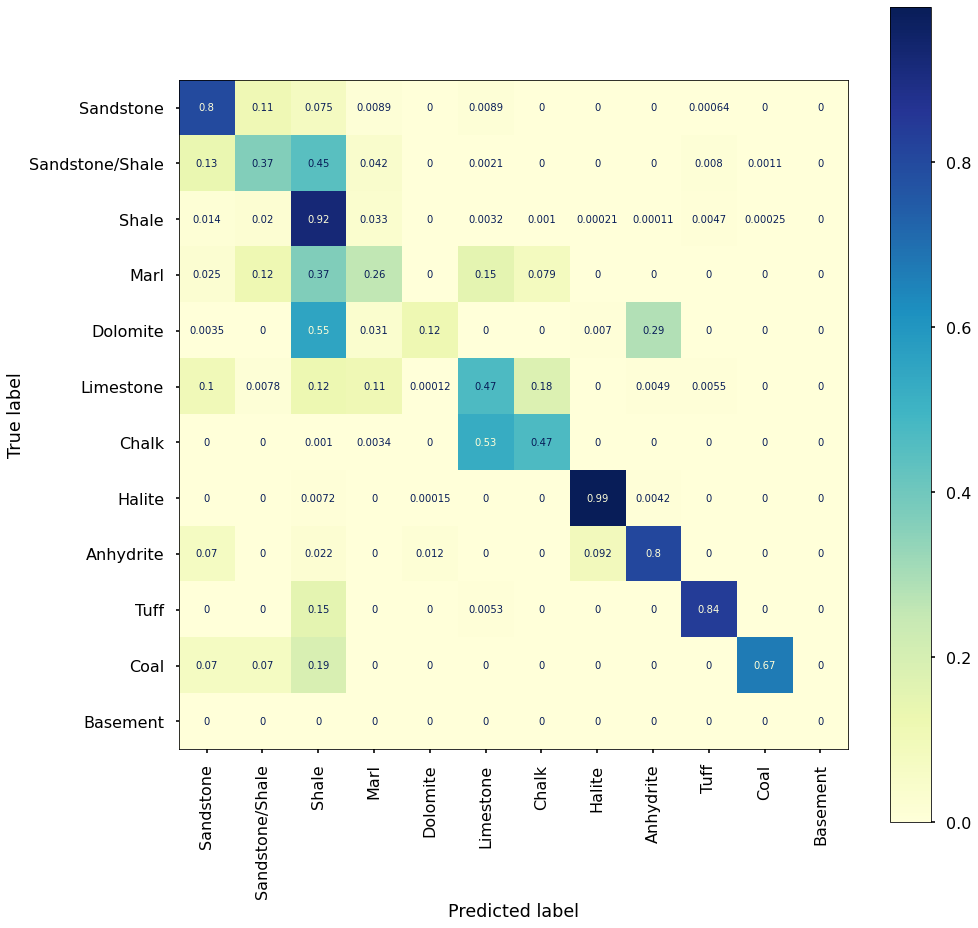

In [99]:
fig, ax = plt.subplots(figsize=(15,15))

disp.plot(ax=ax, xticks_rotation='vertical', cmap='YlGnBu')

plt.show()

# Performance per well

In [84]:
csv_hidden_test['y_true'] = y_true
csv_hidden_test['y_pred'] = y_pred

In [86]:
csv_hidden_test['match'] = csv_hidden_test['y_true'] == csv_hidden_test['y_pred']

In [87]:
csv_hidden_test.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,y_true,y_pred,match
0,15/9-23,1518.280,433906.75,6460000.5,-1493.241821,HORDALAND GP.,Skade Fm.,15.506232,NaN,NaN,...,0.109706,NaN,NaN,88.968864,NaN,65000,3.0,2,2,True
1,15/9-23,1518.432,433906.75,6460000.5,-1493.393799,HORDALAND GP.,Skade Fm.,18.524611,NaN,NaN,...,-0.006418,NaN,NaN,92.287186,NaN,65000,3.0,2,2,True
2,15/9-23,1518.584,433906.75,6460000.5,-1493.545776,HORDALAND GP.,Skade Fm.,18.855669,NaN,NaN,...,0.022769,NaN,NaN,95.605499,NaN,65000,3.0,2,2,True
3,15/9-23,1518.736,433906.75,6460000.5,-1493.697754,HORDALAND GP.,Skade Fm.,19.163353,NaN,NaN,...,0.024972,NaN,NaN,98.923820,NaN,65000,3.0,2,2,True
4,15/9-23,1518.888,433906.75,6460000.5,-1493.849609,HORDALAND GP.,Skade Fm.,18.489744,NaN,0.849849,...,0.024527,NaN,NaN,102.242142,NaN,65000,3.0,2,2,True


In [92]:
csv_hidden_test.groupby('WELL')['match'].apply(lambda x: x.sum() / len(x)).sort_values()

WELL
16/7-6       0.693896
17/4-1       0.708471
15/9-23      0.725662
35/11-5      0.750278
16/2-7       0.783189
25/10-9      0.809325
35/9-7       0.856982
31/2-21 S    0.864796
34/3-2 S     0.887525
31/2-10      0.904572
Name: match, dtype: float64

Let's check on the low match wells to understand where the model misses the prediction.

## Well plots

In [93]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [95]:
well_16_7_6 = csv_hidden_test.loc[csv_hidden_test['WELL']=='16/7-6', :]

In [96]:
well_16_7_6.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,y_true,y_pred,match
22746,16/7-6,1110.9344,443865.8125,6458302.5,-1085.912354,HORDALAND GP.,Utsira Fm.,NaN,1.267743,1.336313,...,-1.139011,NaN,NaN,NaN,NaN,65000,2.0,2,2,True
22747,16/7-6,1111.0864,443865.8125,6458302.5,-1086.064331,HORDALAND GP.,Utsira Fm.,NaN,1.269506,1.330815,...,-1.139011,NaN,NaN,NaN,NaN,65000,2.0,2,2,True
22748,16/7-6,1111.2384,443865.8125,6458302.5,-1086.216309,HORDALAND GP.,Utsira Fm.,NaN,1.245485,1.309160,...,-1.139011,NaN,NaN,NaN,NaN,65000,2.0,2,2,True
22749,16/7-6,1111.3904,443865.8125,6458302.5,-1086.368286,HORDALAND GP.,Utsira Fm.,12.113527,1.220606,1.290807,...,-1.139011,NaN,NaN,NaN,NaN,65000,2.0,2,2,True
22750,16/7-6,1111.5424,443865.8125,6458302.5,-1086.520264,HORDALAND GP.,Utsira Fm.,12.107354,1.203916,1.270102,...,-1.139011,NaN,NaN,NaN,NaN,65000,2.0,2,2,True


In [94]:
logs_in_tracks = {
    'True': ('RHOB',),
    'P-velocity': ('vp',),
    'S-velocity': ('vs',),
    'P32': ('P32',)
}

In [ ]:
def log_plot(df, logs_in_tracks, units):

    try:
        y = df['DEPTH_MD'].values.astype(float)
    except KeyError:
        y = df.index.values

    track_names = list(logs_in_tracks.keys())
    number_of_tracks = len(track_names)

    fig = make_subplots(rows=1,
                        cols=number_of_tracks,
                        shared_yaxes=True,
                        subplot_titles=track_names)

    for col, track in enumerate(logs_in_tracks.items(), start=1):
        track_name, log_names = track

        for log_name in log_names:
            log_values = df[log_name].values.astype(float)
            fig.add_trace(go.Scatter(x=log_values, y=y, name=log_name),
                          row=1, col=col)

        track_units = f"{df[log_name].pint.units:~P}"
        fig.update_xaxes(title_text=track_units,
                         row=1, col=col)

    if units == 'si':
        depth_unit = 'm'
    else:
        depth_unit = 'ft'

    fig.update_layout(height=800, width=800,
                      title_text=f"Well logs in {units.title()} units",
                      yaxis_title=f"MD [{depth_unit}]")
    fig.update_yaxes(autorange="reversed")
    fig.show()

# To be continued

# Models summary

In [100]:
import seaborn as sns

In [101]:
models_score = pd.DataFrame({'Model': ['XGBoost', 'XGB No Splits','XGBoost Groups', 'RF NS'],
                             'Open': [-0.538, -0.539, -0.567, -0.574],
                             'Hidden': [-0.570, -0.541, -0.506, -0.542]})

In [102]:
models_score

,Model,Open,Hidden
0,XGBoost,-0.538,-0.570
1,XGB No Splits,-0.539,-0.541
2,XGBoost Groups,-0.567,-0.506
3,RF NS,-0.574,-0.542


In [105]:
models_score_melt = pd.melt(models_score, id_vars=['Model'], var_name='Test_type', value_name='Score')

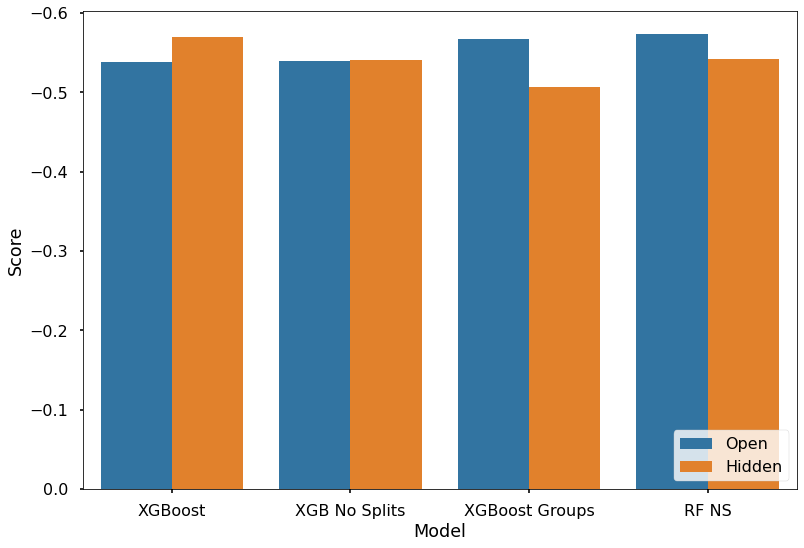

In [112]:
sns.barplot(x='Model', y='Score', hue='Test_type', data=models_score_melt)

plt.gca().invert_yaxis()

plt.legend(loc="lower right")

plt.show()